# Volume 3: Recurrent Neural Networks    
    <Name>
    <Class>
    <Date>

In [16]:
!pip install --upgrade music21
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import glob
import os
import gzip
import tarfile
from torchvision import datasets
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from random import randint

In [ ]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
        datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
        out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))


# Problem 1 #

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the 114215 Notes and Chords as strings.
There are many element types in MIDI files, so be sure to only look for Notes and Chords.
For the Chords, join the pitches of the Notes in the Chords with a . as in (D3.D2).

Print the length of your list and the number of unique Notes and Chords.


In [ ]:
# download the data
filepath = "./"
download_data(filepath)

100%|██████████| 430509/430509 [00:00<00:00, 13108996.55it/s]

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


In [6]:
def order_pitches(pitches):
    """
    Orders pitches in a chord.

    Args:
        pitches: element.pitches object where element is a chord.Chord

    Returns:
        sorted list of strings for each pitch in the chord
    """
    return sorted(list(set([str(n) for n in pitches])))

def parse_files(filepath):
    """
    Parses MIDI files located in the specified directory path and extracts notes and chords.

    Args:
    - filepath (str): The directory path containing MIDI files to parse.

    Returns:
    - list: A list of strings representing notes and chords extracted from MIDI files.
    """

    # Get file names of MIDI files in the specified directory
    file_names = glob.glob(filepath + "/mozart_sonatas/mozart_sonatas/*.mid")

    # Initialize a list to store notes and chords
    notes_and_chords = []

    # Iterate through each MIDI file
    for file in file_names:
        # Parse the MIDI file
        midi = converter.parse(file)

        # Extract notes and chords from MIDI file
        notes_to_parse = instrument.partitionByInstrument(midi).parts.stream().recurse()

        # Iterate through each element in the parsed notes
        for element in notes_to_parse:
            # If the element is a single note
            if isinstance(element, note.Note):
                notes_and_chords.append(str(element.pitch))

            # If the element is a chord
            elif isinstance(element, chord.Chord):
                # Order the pitches of the chord
                pitches = order_pitches(element.pitches)
                # Convert the ordered pitches to a string and append to the list
                notes_and_chords.append('.'.join(pitches))

    return notes_and_chords

In [8]:
# get notes & chords
pitches = parse_files(filepath)

print(f'We have {len(pitches)} Notes and Chords as strings')

We have 114215 Notes and Chords as strings


# Problem 2 #

Using the list returned in Problem 1, create the training, validation, and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.

2) Split the data into Long tensors of length 100.

3) Create the labels.

4) Randomly split the data into training, validation, and test sets using an 70/15/15 split (use torch.utils.data.random(data,lengths) where lengths=[0.7, 0.15, 0.15]).

5) Create the DataLoaders for these sets of data, using batch_size=128 for the training data and batch_size=32 for the validation and test data; also, set shuffle=True for the training data and False for the validation and test data (this is common practice in Deep Learning).


Print the length of each DataLoader (they should be 624, 536, and 536, respectively).

In [11]:
# create an integer map for the pitches & convert to integers
unique_pitches = list(set(pitches))
pitches_to_int = {pitch: i for i, pitch in enumerate(unique_pitches)}
converted_pitches = [pitches_to_int[pitch] for pitch in pitches]

def create_loaders(notes):
    """
    Creates data loaders for training, validation, and testing from a list of notes.

    Args:
    - notes (list): A list of notes represented as integers or tokens.

    Returns:
    - tuple: A tuple containing four elements:
        1. test (list): The test dataset, each element is a pair of input sequence (tensor) and target note (integer or token).
        2. train_loader (DataLoader): DataLoader for the training dataset.
        3. val_loader (DataLoader): DataLoader for the validation dataset.
        4. test_loader (DataLoader): DataLoader for the test dataset.
    """

    # Initialize a list to store tensors
    tensors = []

    # Split the data into Long tensors of length 100
    for i in range(len(notes) - 100):
        tensors.append([torch.LongTensor(notes[i: i+100]), notes[i+100]])

    # Calculate lengths for splitting into train, validation, and test sets
    total_count = len(tensors)
    train_count = int(0.7 * total_count)
    val_count = int(0.15 * total_count)
    test_count = total_count - train_count - val_count

    # Randomly split for train, test, and validate set
    train, val, test = random_split(tensors, [train_count, val_count, test_count])

    # Create DataLoader for the train set
    train_loader = DataLoader(train, batch_size=128, shuffle=True, drop_last=True)

    # Create DataLoader for the validation set
    val_loader = DataLoader(val, batch_size=32, shuffle=False)

    # Create DataLoader for the test set
    test_loader = DataLoader(test, batch_size=32, shuffle=False)

    # Print lengths of train, validation, and test loaders
    print("Train Loader Length:", len(train_loader))
    print("Validation Loader Length:", len(val_loader))
    print("Test Loader Length:", len(test_loader))

    return test, train_loader, val_loader, test_loader

test, train_loader, val_loader, test_loader = create_loaders(converted_pitches)


Train Loader Length: 624
Validation Loader Length: 535
Test Loader Length: 535


# Problem 3 #

Create an LSTM network class.
Have a hidden layer size of 256, and include at least $3$ LSTM layers.
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for a total of at least $3$ total BatchNorm layers.
The final layer should be a Softmax activation.

Initialize the model.
Define the loss as CrossEntropyLoss, and define the optimizer as RMSprop.

Train the model for 30 epochs.
Make sure to reinitialize the hidden states (h0, h1) for each training batch.
After taking a backwards step during training, scale the gradients using
nn.utils.clip_grad_norm_(model.parameters(), 5).
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of every epoch, calculate the validation accuracy and mean loss on the validation data.
Remember to change the model to eval() mode when running the validation data and then train() when running on the training data.
The hidden states (h0, h1) will also need to be reinitialized for each validation batch.

Once the training is complete, plot the training and validation losses versus epochs on the same plot.
Also, plot the validation accuracy versus epochs.
Then, print the final test accuracy by running the finished model on the test data.

In [12]:
class RNN(nn.Module):
    """ Recurrent Neural Network Class """

    def __init__(self, n_notes, embedding_dim):
        super(RNN, self).__init__()

        # initialize layers
        self.hidden_size = 256
        self.num_layers = 3     # num_layers is the number of layers in the LSTM
        self.n_notes = n_notes  # n_notes is the number of unique pitches

        self.embedding = nn.Embedding(n_notes, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers, batch_first=True)

        # use BatchNorm1d after the last LSTM layer & each Linear layer
        self.batch1 = nn.BatchNorm1d(self.hidden_size)  # first BatchNorm layer after the last LSTM layer
        self.batch2 = nn.BatchNorm1d(self.n_notes)      # second BatchNorm layer after the first Linear layer
        self.batch3 = nn.BatchNorm1d(self.n_notes)      # third BatchNorm layer after the second Linear layer

        self.linear1 = nn.Linear(self.hidden_size, self.n_notes)
        self.linear2 = nn.Linear(self.n_notes, self.n_notes)

        self.softmax = nn.Softmax(dim=1)  # using Softmax for the final activation
        self.relu = nn.ReLU()

    def forward(self, x, hidden):
        # forward pass
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        out = self.batch1(lstm_out[:,-1])

        layer_1 = self.relu(self.linear1(out))
        out2 = self.batch2(layer_1)

        layer_2 = self.relu(self.linear2(out2))
        out3 = self.batch3(layer_2)

        # Apply Softmax on the output
        return self.softmax(out3), hidden


    def init_hidden(self,batch_size):
        # initialize the hidden layers
        weight = next(self.parameters()).data
        h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return (h0, h1)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNN(668, 32)  # Initialize the model with the number of unique notes and embedding dimension
model.to(device)
objective = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.001)

mean_loss_list = []
val_accs = []
mean_val_loss_list = []

for epoch in range(30):
    model.train()
    loss_list = []
    val_loss_list = []
    (h0, h1) = model.init_hidden(128)

    for batch, (x_truth, y_truth) in enumerate(train_loader):
        x_truth, y_truth = x_truth.to(device), y_truth.to(device)
        optimizer.zero_grad()
        output, (h0, h1) = model(x_truth, (h0, h1))
        h0 = h0.detach()
        h1 = h1.detach()
        loss = objective(output, y_truth)
        loss_list.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    mean_loss = sum(loss_list) / len(loss_list)
    mean_loss_list.append(mean_loss)

    model.eval()
    val_correct = 0
    for x_truth, y_truth in val_loader:
        x_truth, y_truth = x_truth.to(device), y_truth.to(device)
        (h0, h1) = model.init_hidden(x_truth.shape[0])
        y_hat, _ = model(x_truth, (h0, h1))
        loss = objective(y_hat, y_truth)
        val_loss_list.append(loss.item())
        val_correct += torch.eq(y_truth, y_hat.argmax(1)).sum().item()

    mean_val_loss = sum(val_loss_list) / len(val_loss_list)
    mean_val_loss_list.append(mean_val_loss)
    val_accuracy = val_correct / len(val_loader.dataset)
    val_accs.append(val_accuracy)



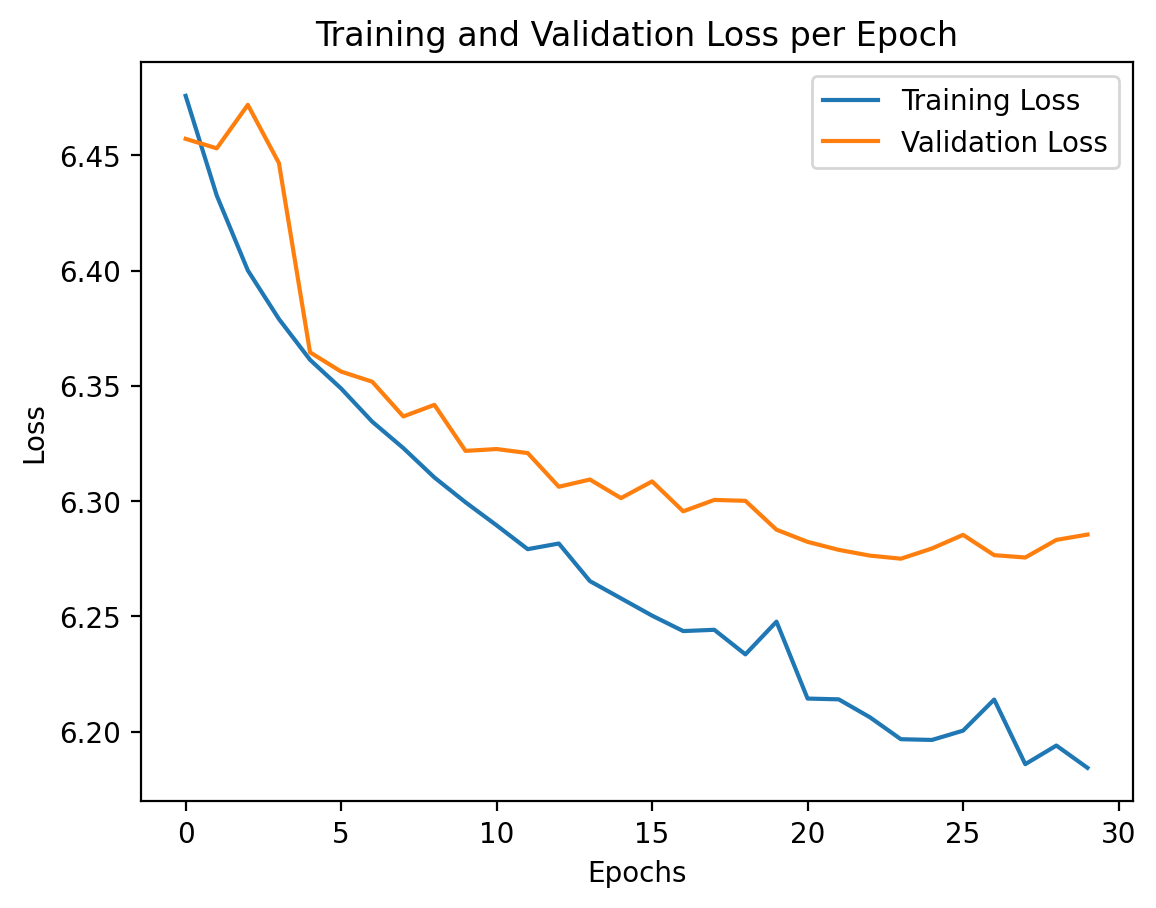

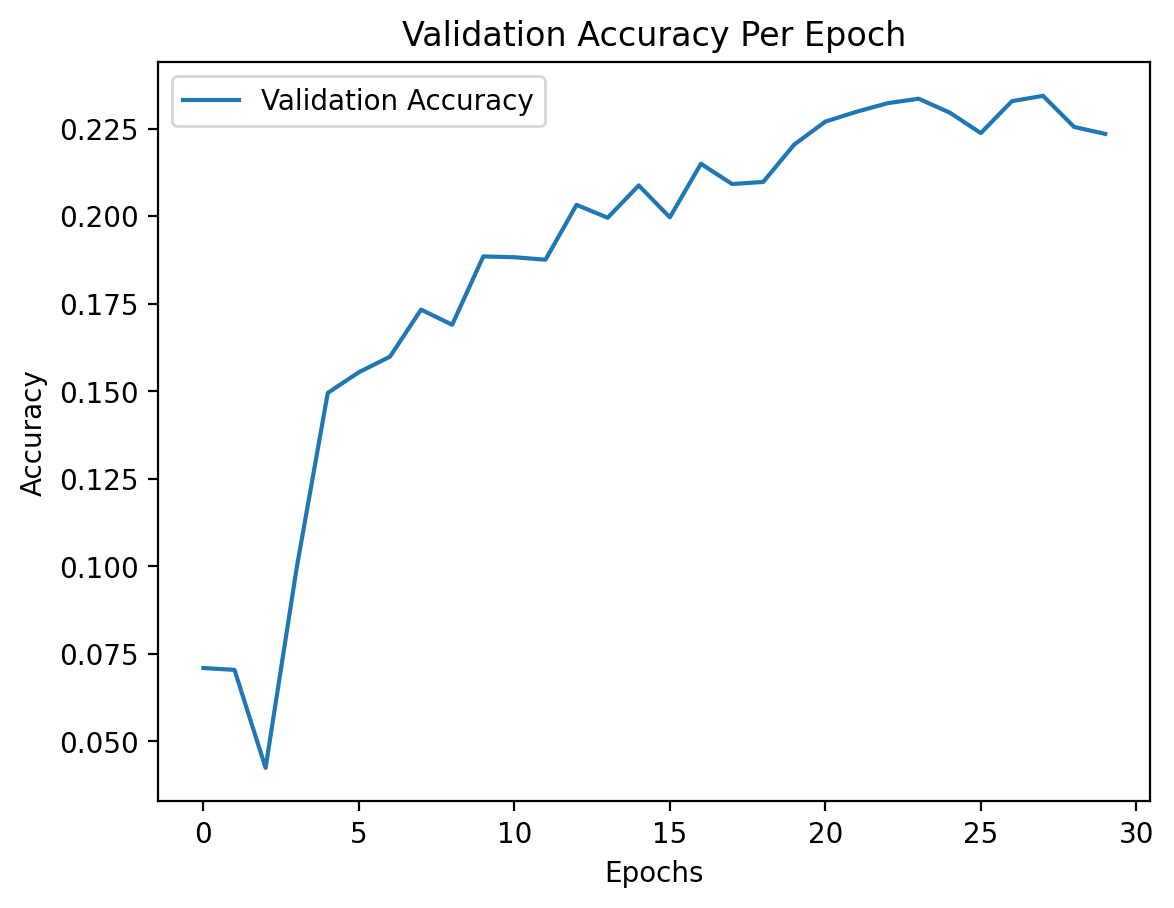

Final Test Accuracy: 0.22327374693305294


In [15]:
plt.plot(mean_loss_list, label='Training Loss')
plt.plot(mean_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_accs, label='Validation Accuracy')
plt.title('Validation Accuracy Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.eval()
test_correct = 0
for x, y_truth in test_loader:
    x, y_truth = x.to(device), y_truth.to(device)
    (h0, h1) = model.init_hidden(x.shape[0])
    y_hat, _ = model(x, (h0, h1))
    test_correct += torch.eq(y_truth, y_hat.argmax(1)).sum().item()
test_accuracy = test_correct / len(test_loader.dataset)
print("Final Test Accuracy:", test_accuracy)

# Problem 4 #

Write a function that randomly chooses a sequence in the test data (which has length 10) and predicts the next $n$ elements, defaulting to 500.
Convert the predicted elements to pitches, and return them as a list of length $n$.

In [17]:
def load_model(filename):
    """ Load a saved model to continue training or evaluate """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # n_notes is the number of unique pitches
    model = Network(n_notes,32)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

    checkpoint = torch.load(filename,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.eval() # Toggle evaluation mode

    return model, criterion, optimizer

In [18]:
int_to_pitches = dict((v, k) for k, v in pitches_to_int.items())  # Ensure this dictionary is properly defined elsewhere

def generate(n=500):
    model.eval()  # Ensure the model is in evaluation mode
    test_loader = DataLoader(test, batch_size=1, shuffle=True)  # Assuming 'test' is defined

    # Get a random sequence from the shuffled test_loader
    for x, _ in test_loader:
        sequence = x.squeeze().tolist()  # Assuming the input x is a tensor of the correct shape
        break

    predictions = []

    for _ in range(n):
        hidden_states = model.init_hidden(1)
        # Prepare the tensor from the last 10 elements of the current sequence
        ten_seq = torch.LongTensor(sequence[-10:]).to(device).unsqueeze(0)
        pred, _ = model(ten_seq, hidden_states)
        pitch = pred.argmax().item()
        predictions.append(pitch)  # Append predicted pitch ID to predictions list
        sequence.append(pitch)  # Update sequence with the new pitch ID

    # Convert predicted pitch IDs to actual pitches
    return [int_to_pitches[p] for p in predictions]  # Convert only predicted IDs, not the entire sequence

In [19]:
print(generate())

['C4', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'D5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5', 'G4', 'G5

# Problem 5 #

Convert the predictions from Problem 4 into Music21 Note and Chord objects and save it as 'mozart.mid'. Embed your music file into the notebook.

In [20]:
def generate_chords(notes, chord_pitches):
    chord_notes = []
    pitches = chord_pitches.split('.')
    for pitch in pitches:
        new_note = note.Note(pitch)
        new_note.storedInstrument = instrument.Piano()
        chord_notes.append(new_note)
    new_chord = chord.Chord(chord_notes)
    new_chord.offset = offset
    notes.append(new_chord)

# Assuming generate function provides a list of pitch names
song = generate()
notes = []
offset = 0  # Initialize offset for each note or chord

for key in song:
    if "." in key:
        generate_chords(notes, key)
    else:
        new_note = note.Note(key)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        notes.append(new_note)
    offset += 0.5  # Increment offset to separate notes/chords in time

midi_stream = stream.Stream(notes)
midi_stream.write('midi', fp='mozart.mid')  # Correct file extension

'mozart.mid'

In [5]:
from IPython.display import Audio

# Path to your MIDI file
file_path = 'mozart.midi'

# Embed the MIDI file
Audio(file_path)